In [5]:
from Code_Testing_Scripts.custom_loss_fn_tester import test_custom_loss
import numpy as np
import torch




In [6]:
class HistogramLoss(torch.nn.Module):
    def __init__(self, num_bins=256):
        super(HistogramLoss, self).__init__()
        self.num_bins = num_bins

    def histogram_intersection(hist1, hist2):
        min_hist = torch.min(hist1, hist2)
        return torch.sum(min_hist)

    def forward(self, input_image, target_image):
        hist_input = torch.histc(input_image, bins=self.num_bins, min=0, max=255)
        hist_target = torch.histc(target_image, bins=self.num_bins, min=0, max=255)

        hist_input = hist_input / hist_input.sum()
        hist_target = hist_target / hist_target.sum()

        loss = 1 - self.histogram_intersection(hist_input, hist_target)

        return loss

In [7]:
class ffACBLoss(torch.nn.Module):
    def __init__(self, zero_weighting=1, nonzero_weighting=1, fullframe_weighting=1):
        """
        Initializes the ACB-MSE Loss Function class with weighting coefficients.

        Args:
        - zero_weighting: a scalar weighting coefficient for the MSE loss of zero pixels
        - nonzero_weighting: a scalar weighting coefficient for the MSE loss of non-zero pixels
        """
        super().__init__()   
        self.zero_weighting = zero_weighting
        self.nonzero_weighting = nonzero_weighting
        self.fullframe_weighting = fullframe_weighting
        self.mse_loss = torch.nn.MSELoss(reduction='mean')

    def forward(self, reconstructed_image, target_image):
        """
        Calculates the weighted mean squared error (MSE) loss between target_image and reconstructed_image.
        The loss for zero pixels in the target_image is weighted by zero_weighting, and the loss for non-zero
        pixels is weighted by nonzero_weighting.

        Args:
        - target_image: a tensor of shape (B, C, H, W) containing the target image
        - reconstructed_image: a tensor of shape (B, C, H, W) containing the reconstructed image

        Returns:
        - weighted_mse_loss: a scalar tensor containing the weighted MSE loss
        """
        zero_mask = (target_image == 0)
        nonzero_mask = ~zero_mask

        values_zero = target_image[zero_mask]
        values_nonzero = target_image[nonzero_mask]

        corresponding_values_zero = reconstructed_image[zero_mask]
        corresponding_values_nonzero = reconstructed_image[nonzero_mask]

        zero_loss = self.mse_loss(corresponding_values_zero, values_zero)
        nonzero_loss = self.mse_loss(corresponding_values_nonzero, values_nonzero)
        full_frame_loss = self.mse_loss(reconstructed_image, target_image)

        if torch.isnan(zero_loss):
            zero_loss = 0
        if torch.isnan(nonzero_loss):
            nonzero_loss = 0

        weighted_mse_loss = (self.zero_weighting * zero_loss) + (self.nonzero_weighting * nonzero_loss) + (self.fullframe_weighting * full_frame_loss)

        return weighted_mse_loss

class True3DLoss(torch.nn.Module):
    def __init__(self, zero_weighting=1, nonzero_weighting=1, timesteps=100):
        """
        # Number of dp is related to timestep size. 1,000 = 3dp, 10,000 = 4dp, 100,000 = 5dp, 1,000,000 = 6dp etc
        
        """
        super().__init__()   
        self.mse_loss = torch.nn.MSELoss(reduction='mean')
        self.timesteps = timesteps
        self.zero_weighting = zero_weighting
        self.nonzero_weighting = nonzero_weighting

    def ACB_MSE_Loss (self, reconstructed, target):
        reconstructed_image = reconstructed.clone()
        target_image = target.clone()
        """
        Calculates the weighted mean squared error (MSE) loss between target_image and reconstructed_image.
        The loss for zero pixels in the target_image is weighted by zero_weighting, and the loss for non-zero
        pixels is weighted by nonzero_weighting.

        Args:
        - target_image: a tensor of shape (B, C, H, W) containing the target image
        - reconstructed_image: a tensor of shape (B, C, H, W) containing the reconstructed image

        Returns:
        - weighted_mse_loss: a scalar tensor containing the weighted MSE loss
        """
        zero_mask = (target_image == 0)
        nonzero_mask = ~zero_mask

        values_zero = target_image[zero_mask]
        values_nonzero = target_image[nonzero_mask]

        corresponding_values_zero = reconstructed_image[zero_mask]
        corresponding_values_nonzero = reconstructed_image[nonzero_mask]

        zero_loss = self.mse_loss(corresponding_values_zero, values_zero)
        nonzero_loss = self.mse_loss(corresponding_values_nonzero, values_nonzero)

        if torch.isnan(zero_loss):
            zero_loss = 0
        if torch.isnan(nonzero_loss):
            nonzero_loss = 0

        weighted_mse_loss = (self.zero_weighting * zero_loss) + (self.nonzero_weighting * nonzero_loss)

        return weighted_mse_loss

    def expand_data_to_new_dimPREFERED(self, input_tensor):
        """
        # Number of dp is related to timestep size. 1,000 = 3dp, 10,000 = 4dp, 100,000 = 5dp, 1,000,000 = 6dp etc
        
        """

        # QUANITSE VALUES IN THE TENSOR TO steps of (1/timesteps) then multiply by timesteps to arrive at integers (this simplifies to juyt * timestep then round)
        #quantised_tensor = torch.round(input_tensor * self.timesteps) # / timesteps

        # Determine the number of classes (third dimension size)
        num_classes = self.timesteps #int(input_tensor.max()) + 1

        # Convert the input tensor to indices
        indices = input_tensor.long()

        # Create a mask for non-zero values
        #non_zero_mask = input_tensor != 0

        # Create one-hot encoded tensor
        one_hot_encoded = torch.nn.functional.one_hot(indices, num_classes=num_classes).float()

        # Apply the mask to exclude zero values
        #one_hot_encoded = one_hot_encoded * non_zero_mask.unsqueeze(-1)

        # Permute dimensions to move the new dimension to the front
        #one_hot_encoded = one_hot_encoded.permute(0, 1, 4, 2, 3)
        
        return one_hot_encoded

    def expand_data_to_new_dim(self, input_tensor):
        input_tensor = (input_tensor * self.timesteps) - 1

        input_tensor = torch.where(input_tensor < 0, torch.tensor(0.0), input_tensor)   # could try input_tensor + 1.0 instead of  torch.tensor(0.0)

        # Assuming you have 'indices' and 'num_classes' defined
        num_classes =  self.timesteps
        indices = input_tensor.long()

        # Reshape the indices tensor for compatibility with scatter_
        reshaped_indices = indices.view(indices.size(0), indices.size(1), -1)

        # Create a tensor of zeros with the same shape as 'reshaped_indices'
        one_hot_encoded = torch.zeros(reshaped_indices.size(0), reshaped_indices.size(1), num_classes, reshaped_indices.size(2), requires_grad=True)
        
        # Use scatter to fill the one-hot encoded tensor (without in-place operation)
        one_hot_encoded = one_hot_encoded.scatter(2, reshaped_indices.unsqueeze(2), 1)

        # Convert the tensor to float
        one_hot_encoded = one_hot_encoded.float()

        return one_hot_encoded

    def forward(self, reconstructed_image, target_image):
        reconstructed_3D_view = self.expand_data_to_new_dim(reconstructed_image)
        target_3D_view = self.expand_data_to_new_dim(target_image)
        true3d_loss = self.ACB_MSE_Loss(reconstructed_3D_view, target_3D_view)
        return true3d_loss

In [8]:
class NEWEST3dloss(torch.nn.Module):
    def __init__(self, timesteps=100):

        """
        # Number of dp is related to timestep size. 1,000 = 3dp, 10,000 = 4dp, 100,000 = 5dp, 1,000,000 = 6dp etc
        
        """
        super().__init__()   
        self.mse_loss = torch.nn.MSELoss(reduction='mean')
        self.timesteps = timesteps
    
    def transform_to_3d_coordinates(self, input_tensor):

        if len(input_tensor.shape) == 1:
            # X
            m = input_tensor.size()[0]
            n = 1
            b = 1

        if len(input_tensor.shape) == 2:
            # X, Y
            m, n = input_tensor.size()
            b = 1

        if len(input_tensor.shape) == 3:
            # Channel, X, Y
            c, m, n = input_tensor.size()
            b = 1

        if len(input_tensor.shape) == 4:
            # Batch, Channel, X, Y
            b, c, m, n = input_tensor.size()

        # create a batches tensor
        batches = torch.arange(b).repeat_interleave(m*n).view(-1,1)

        # Create indices tensor
        indices = torch.stack( torch.meshgrid(torch.arange(m), torch.arange(n), indexing='ij'), dim=-1).view(-1, 2) 
        indices = indices.repeat(b, 1)

        # Reshape the input tensor and concatenate with indices
        output_tensor = torch.cat((batches,  indices, input_tensor.view(-1, 1)), dim=1)

        return output_tensor


    def forward(self, reconstructed_image, target_image):
        reconstructed_image = self.transform_to_3d_coordinates(reconstructed_image)
        target_image = self.transform_to_3d_coordinates(target_image,)
        true3d_loss = self.mse_loss(reconstructed_image, target_image)

        return true3d_loss

In [9]:
class NEWEST3dloss2(torch.nn.Module):
    def __init__(self, b, m, n):

        """
        # Number of dp is related to timestep size. 1,000 = 3dp, 10,000 = 4dp, 100,000 = 5dp, 1,000,000 = 6dp etc
        
        """
        super().__init__()   
        self.mse_loss = torch.nn.MSELoss(reduction='mean')
    
        # create a batches tensor
        batches = torch.arange(b).repeat_interleave(m*n).view(-1,1)

        # Create indices tensor
        indices = torch.stack( torch.meshgrid(torch.arange(m), torch.arange(n), indexing='ij'), dim=-1).view(-1, 2) 
        indices = indices.repeat(b, 1)

        self.batches = batches  
        self.indices = indices

    def transform_to_3d_coordinates(self, input_tensor):
        # Reshape the input tensor and concatenate with indices
        output_tensor = torch.cat((self.batches, self.indices, input_tensor.view(-1, 1)), dim=1)

        return output_tensor


    def forward(self, reconstructed_image, target_image):
        reconstructed_image = self.transform_to_3d_coordinates(reconstructed_image)
        target_image = self.transform_to_3d_coordinates(target_image,)
        true3d_loss = self.mse_loss(reconstructed_image, target_image)

        return true3d_loss



In [10]:
test_custom_loss( torch.nn.KLDivLoss(), torch.nn.BCEWithLogitsLoss(), torch.nn.L1Loss(), torch.nn.MSELoss(), NEWEST3dloss(),NEWESTACB3dloss2024(1, 100, 10), ffACBLoss(1.0, 1.0, 1.0), ffACBLoss(0.5, 0.5, 1.5))

Testing loss function: KLDivLoss
Time taken to compute loss:


c:\Users\Ada\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


0.11262260001967661
Gradient computation successful!
Testing loss function: BCEWithLogitsLoss
Time taken to compute loss:
0.12547319999430329
Gradient computation successful!
Testing loss function: L1Loss
Time taken to compute loss:
0.10983630002010614
Gradient computation successful!
Testing loss function: MSELoss
Time taken to compute loss:
0.083573299983982
Gradient computation successful!
Testing loss function: NEWEST3dloss
Time taken to compute loss:
0.3586739999882411
Gradient computation successful!
Testing loss function: NEWESTACB3dloss2024
Loss function cannot work with shape (x) Check loss fn code for error.
 Failed wil error message:
 Sizes of tensors must match except in dimension 1. Expected size 1000 but got size 10 for tensor number 2 in the list.
Time taken to compute loss:


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1000 but got size 100 for tensor number 2 in the list.

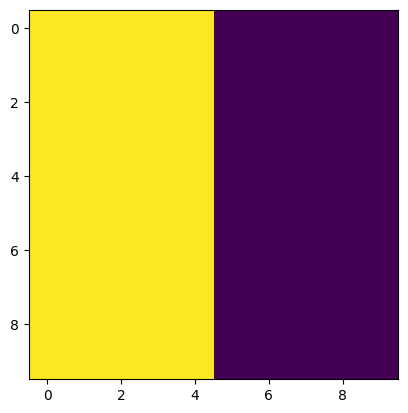

In [ ]:
import matplotlib.pyplot as plt

dummy_img1 = torch.zeros(1,1,10,10)
#set 50% of pixels to hits
dummy_img1[:,:,:,0:5] = 1.0
plt.imshow(dummy_img1[0,0])

In [ ]:
import torch
import torch.autograd.profiler as profiler

# Instantiate your loss module
loss_module = NEWEST3dloss()

# Create some dummy input tensor
input_tensor = torch.randn(4, 1, 64, 64)

# Run the profiler on the transform_to_3d_coordinates method
with profiler.profile(record_shapes=True) as prof:
    output_tensor = loss_module.forward(input_tensor, input_tensor)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::copy_        21.29%     362.000us        21.29%     362.000us      36.200us            10  
                    aten::cat        18.06%     307.000us        39.47%     671.000us     167.750us             4  
      aten::repeat_interleave         9.12%     155.000us        44.76%     761.000us     190.250us             4  
                 aten::arange         5.41%      92.000us         9.94%     169.000us      14.083us            12  
           aten::index_select         4.35%      74.000us         4.47%      76.000us      38.000us             2  
-----------------------------  ------------  ------------  ------------ 

In [ ]:
import torch
import torch.autograd.profiler as profiler

# Instantiate your loss module
loss_module = NEWEST3dloss2(4, 64, 64)

# Create some dummy input tensor
input_tensor = torch.randn(4, 1, 64, 64)

# Run the profiler on the transform_to_3d_coordinates method
with profiler.profile(record_shapes=True) as prof:
    output_tensor = loss_module.forward(input_tensor, input_tensor)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::copy_        31.63%     186.000us        31.63%     186.000us      31.000us             6  
                  aten::cat        29.59%     174.000us        68.20%     401.000us     200.500us             2  
                  aten::sum        15.65%      92.000us        20.24%     119.000us     119.000us             1  
             aten::mse_loss         6.46%      38.000us        30.61%     180.000us     180.000us             1  
           aten::as_strided         3.91%      23.000us         3.91%      23.000us       2.556us             9  
---------------------------  ------------  ------------  ------------  ------------  ---

In [ ]:
import torch

# Example 3D tensor
# Replace this with your actual 3D tensor
three_dim_tensor = torch.rand((3, 4, 5))

# Get the indices of non-zero elements in the third dimension
indices_3d = torch.nonzero(three_dim_tensor, as_tuple=False)[:, 2]

# Create a 2D tensor using the indices
two_dim_tensor = indices_3d.view(three_dim_tensor.size(0), three_dim_tensor.size(1))

print("Original 3D Tensor:")
print(three_dim_tensor)
print("\n2D Tensor with Indices:")
print(two_dim_tensor)


RuntimeError: shape '[3, 4]' is invalid for input of size 60

In [ ]:
import torch

# Example 3D tensor
# Replace this with your actual 3D tensor
three_dim_tensor = torch.ones((2, 2, 2))

print("Original 3D Tensor:\n", three_dim_tensor.numpy())

# Get the indices of non-zero elements in the third dimension
indices_3d = torch.nonzero(three_dim_tensor, as_tuple=False)[:, 2]

print("Indices 3D:", indices_3d)




Original 3D Tensor:
 [[[1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]]]
Indices 3D: tensor([0, 1, 0, 1, 0, 1, 0, 1])


In [ ]:
# Reshape the indices to match the size of the original tensor
two_dim_tensor = indices_3d.view(three_dim_tensor.size(0), three_dim_tensor.size(1))

print("Original 3D Tensor:")
print(three_dim_tensor)
print("\n2D Tensor with Indices:")
print(two_dim_tensor)

RuntimeError: shape '[2, 2]' is invalid for input of size 8

In [ ]:
A = np.array([[2, 2], 
            [1, 2]])


C = np.array([[[0, 0],
                [1, 0]],

                [[1, 1],
                [0, 1]]])



print (A)


print (C)



print (A.shape)

print (C.shape)

[[2 2]
 [1 2]]
[[[0 0]
  [1 0]]

 [[1 1]
  [0 1]]]
(2, 2)
(2, 2, 2)


In [ ]:
# Two ideas:


# 1) Stack the 2d matrix 'time_step' number of times and then set all non zero values that match the third dim index to 1 and those that dont to 0 


# 2) create a tensor that is a list of 3d coordinates taken from the cube, so we no longer compare non hits atall, we just comapre the signals in both!?!?!?!?!?

In [ ]:
# genrate random 3D matrix tensor

A = torch.randint(0, 3, (2, 2, 2))
print (A)

tensor([[[1, 0],
         [2, 1]],

        [[0, 2],
         [2, 2]]])


In [ ]:
# genrate random 2D matrix tensor

B = torch.randint(0, 3, (2, 2))
print (B)

tensor([[2, 1],
        [2, 2]])


In [ ]:
# turn 2d tensor into a tensor of shape (4, 3) where the first dim (4) corrsesponds to each element in the 2d tensor and the second dim (3) corresponds to the 3d coordinates of that element (x index, y index, value)


In [ ]:
import numpy as np

# Your 2D tensor of shape (m, n)
input_tensor = np.array([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]])

# Get the shape of the input tensor
m, n = input_tensor.shape

# Create an array of indices corresponding to the elements in the 2D tensor
indices = np.array(list(np.ndindex((m, n))))

# Reshape the input tensor and indices to get the desired output tensor shape
output_tensor = np.hstack((indices, input_tensor.reshape(-1, 1)))

# Output the resulting tensor
print(output_tensor)


[[0 0 1]
 [0 1 2]
 [0 2 3]
 [1 0 4]
 [1 1 5]
 [1 2 6]
 [2 0 7]
 [2 1 8]
 [2 2 9]]


In [ ]:
import torch

def transform_to_3d_coordinates(input_tensor):
    m, n = input_tensor.size()

    # Create indices tensor
    indices = torch.stack(torch.meshgrid(torch.arange(m), torch.arange(n), indexing='ij'), dim=-1).view(-1, 2)

    # Reshape the input tensor and concatenate with indices
    output_tensor = torch.cat((indices, input_tensor.view(-1, 1)), dim=1)

    return output_tensor

# Example usage:
input_tensor = torch.tensor([[1, 2, 3],
                             [4, 5, 6],
                             [7, 8, 9]], dtype=torch.float32)

output_tensor = transform_to_3d_coordinates(input_tensor)
print(output_tensor)


tensor([[0., 0., 1.],
        [0., 1., 2.],
        [0., 2., 3.],
        [1., 0., 4.],
        [1., 1., 5.],
        [1., 2., 6.],
        [2., 0., 7.],
        [2., 1., 8.],
        [2., 2., 9.]])


In [ ]:
import torch

def transform_to_3d_coordinates(input_tensor):

    if len(input_tensor.shape) == 1:
        # X
        m = input_tensor.size()[0]
        n = 1
        b = 1

    if len(input_tensor.shape) == 2:
        # X, Y
        m, n = input_tensor.size()
        b = 1

    if len(input_tensor.shape) == 3:
        # Channel, X, Y
        c, m, n = input_tensor.size()
        b = 1

    if len(input_tensor.shape) == 4:
        # Batch, Channel, X, Y
        b, c, m, n = input_tensor.size()

    # create a batches tensor
    batches = torch.arange(b).repeat_interleave(m*n).view(-1,1)

    # Create indices tensor
    indices = torch.stack( torch.meshgrid(torch.arange(m), torch.arange(n), indexing='ij'), dim=-1).view(-1, 2) 
    indices = indices.repeat(b, 1)

    # Reshape the input tensor and concatenate with indices
    output_tensor = torch.cat((batches,  indices, input_tensor.view(-1, 1)), dim=1)

    return output_tensor

# Example usage:
input_tensor = torch.tensor([[1, 2, 3],
                             [4, 5, 6],
                             [7, 8, 9]], dtype=torch.float32)

# add a channel dim
input_tensor = input_tensor.unsqueeze(0)

# add batch dim
input_tensor = input_tensor.unsqueeze(0)

# make it have 5 batchs
input_tensor = input_tensor.repeat(5,1,1,1)
print(input_tensor)

print(input_tensor.shape)

output_tensor = transform_to_3d_coordinates(input_tensor)
print(output_tensor)

tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]],


        [[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]],


        [[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]],


        [[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]],


        [[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])
torch.Size([5, 1, 3, 3])
tensor([[0., 0., 0., 1.],
        [0., 0., 1., 2.],
        [0., 0., 2., 3.],
        [0., 1., 0., 4.],
        [0., 1., 1., 5.],
        [0., 1., 2., 6.],
        [0., 2., 0., 7.],
        [0., 2., 1., 8.],
        [0., 2., 2., 9.],
        [1., 0., 0., 1.],
        [1., 0., 1., 2.],
        [1., 0., 2., 3.],
        [1., 1., 0., 4.],
        [1., 1., 1., 5.],
        [1., 1., 2., 6.],
        [1., 2., 0., 7.],
        [1., 2., 1., 8.],
        [1., 2., 2., 9.],
        [2., 0., 0., 1.],
        [2., 0., 1., 2.],
        [2., 0., 2., 3.],
        [2., 1., 0., 4.],
        [2., 1., 1., 5.]

In [ ]:
import torch

class TransformTo3DCoordinatesFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_tensor):
        m, n = input_tensor.size()

        # Create indices tensor
        indices = torch.stack(torch.meshgrid(torch.arange(m), torch.arange(n), indexing='ij'), dim=-1).view(-1, 2)

        # Reshape the input tensor and concatenate with indices
        output_tensor = torch.cat((indices, input_tensor.view(-1, 1)), dim=1)

        ctx.save_for_backward(input_tensor)
        return output_tensor

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, = ctx.saved_tensors
        grad_input = grad_output[:, 2:].view(input_tensor.size())
        return grad_input

# Example usage within a loss function:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, input_tensor):
        transformed_tensor = TransformTo3DCoordinatesFunction.apply(input_tensor)
        
        # Your loss computation using the transformed_tensor
        
        loss = transformed_tensor.sum()  # Replace this with your actual loss computation

        return loss

# Example usage:
input_tensor = torch.tensor([[1, 2, 3],
                             [4, 5, 6],
                             [7, 8, 9]], dtype=torch.float32, requires_grad=True)

loss_function = CustomLoss()
loss = loss_function(input_tensor)
loss.backward()

# Access the gradients with respect to the input_tensor
gradients = input_tensor.grad

print(gradients)


tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [ ]:
import torch

# Create a 1D tensor with values from 0 to m-1
arange_m = torch.arange(m)

print (arange_m)

# Create a 1D tensor with values from 0 to n-1
arange_n = torch.arange(n)

print (arange_n)

# Create a meshgrid using the arange_m and arange_n tensors
meshgrid = torch.meshgrid(arange_m, arange_n, indexing='ij')
print (meshgrid)

# Stack the tensors along the last dimension to get a (m x n x 2) tensor
stacked_meshgrid = torch.stack(meshgrid, dim=-1)
print (stacked_meshgrid)

# Reshape the tensor to (m*n, 2)
indices = stacked_meshgrid.view(-1, 2)
print (indices)

tensor([0, 1, 2])
tensor([0, 1, 2])
(tensor([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]]), tensor([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]]))
tensor([[[0, 0],
         [0, 1],
         [0, 2]],

        [[1, 0],
         [1, 1],
         [1, 2]],

        [[2, 0],
         [2, 1],
         [2, 2]]])
tensor([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]])


In [ ]:
import torch
class NEWESTACB3dloss2024(torch.nn.Module):
    def __init__(self, b, m, n):

        """
        # Number of dp is related to timestep size. 1,000 = 3dp, 10,000 = 4dp, 100,000 = 5dp, 1,000,000 = 6dp etc
        
        """
        super().__init__()   
        self.mse_loss = torch.nn.MSELoss(reduction='mean')
        self.zero_weighting = 1
        self.nonzero_weighting = 1


        # create a batches tensor
        batches = torch.arange(b).repeat_interleave(m*n).view(-1,1)

        # Create indices tensor
        indices = torch.stack( torch.meshgrid(torch.arange(m), torch.arange(n), indexing='ij'), dim=-1).view(-1, 2) 
        indices = indices.repeat(b, 1)

        self.batches = batches  
        self.indices = indices

    def transform_to_3d_coordinates(self, input_tensor):
        # Reshape the input tensor and concatenate with indices
        output_tensor = torch.cat((self.batches, self.indices, input_tensor.reshape(-1, 1)), dim=1)

        return output_tensor


    def forward(self, reconstructed_image, target_image):
        reconstructed_image = self.transform_to_3d_coordinates(reconstructed_image)
        target_image = self.transform_to_3d_coordinates(target_image)


        # target_image is a tensor of shape (m, 4)
        # Example:
        # target_image = np.array([[1, 2, 3, 4],
        #                         [5, 6, 7, 0],
        #                         [8, 9, 10, 11]])

        # Identify 0 values in the 4th column of the second dimension

        zero_mask = (target_image[:, 3] == 0)
        nonzero_mask = ~zero_mask

        values_zero = target_image[zero_mask]
        values_nonzero = target_image[nonzero_mask]

        corresponding_values_zero = reconstructed_image[zero_mask]
        corresponding_values_nonzero = reconstructed_image[nonzero_mask]

        zero_loss = self.mse_loss(corresponding_values_zero, values_zero)
        nonzero_loss = self.mse_loss(corresponding_values_nonzero, values_nonzero)

        if torch.isnan(zero_loss):
            zero_loss = 0
        if torch.isnan(nonzero_loss):
            nonzero_loss = 0

        weighted_mse_loss = (self.zero_weighting * zero_loss) + (self.nonzero_weighting * nonzero_loss)

        return weighted_mse_loss

In [ ]:
import torch
import torch.autograd.profiler as profiler

# Instantiate your loss module
loss_module = NEWESTACB3dloss2024(4, 64, 64)

# Create some dummy input tensor
input_tensor = torch.randn(4, 1, 64, 64)

# Run the profiler on the transform_to_3d_coordinates method
with profiler.profile(record_shapes=True) as prof:
    output_tensor = loss_module.forward(input_tensor, input_tensor)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    aten::cat        16.89%     418.000us        34.91%     864.000us     432.000us             2  
                  aten::index        16.28%     403.000us        32.28%     799.000us     199.750us             4  
                  aten::copy_        14.87%     368.000us        14.87%     368.000us      36.800us            10  
                aten::nonzero        13.62%     337.000us        14.42%     357.000us      89.250us             4  
               aten::mse_loss         7.31%     181.000us        16.73%     414.000us     207.000us             2  
-----------------------------  ------------  ------------  ------------ 